SETUP

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Clone repository and pull latest changes.
![ -d vision_transformer ] || git clone --depth=1 https://github.com/google-research/vision_transformer
!cd vision_transformer && git pull

Already up to date.


In [ ]:
# Colab already includes most of the dependencies, so we only install the delta:
!pip install einops>=0.3.0 ml-collections>=0.1.0 aqtp>=0.2.0 clu>=0.0.3 git+https://github.com/google/flaxformer tensorflow-text>=2.9.0

#!pip install -qr vision_transformer/vit_jax/requirements.txt

  Running command git clone --filter=blob:none --quiet https://github.com/google/flaxformer /tmp/pip-req-build-rq4fefc5


IMPORTS

In [ ]:
# Shows all available pre-trained models.
!gsutil ls -lh gs://vit_models/imagenet*
!gsutil ls -lh gs://vit_models/sam
!gsutil ls -lh gs://mixer_models/*

gs://vit_models/imagenet21k+imagenet2012/:
377.57 MiB  2020-11-30T16:17:02Z  gs://vit_models/imagenet21k+imagenet2012/R50+ViT-B_16.npz
330.29 MiB  2020-10-29T17:05:52Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz
 331.4 MiB  2020-10-20T11:48:22Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16.npz
336.89 MiB  2020-10-20T11:47:36Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_32.npz
334.78 MiB  2021-03-12T09:04:16Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_8.npz
  1.13 GiB  2020-10-29T17:08:31Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16-224.npz
  1.14 GiB  2020-10-20T11:53:44Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16.npz
  1.14 GiB  2020-10-20T11:50:56Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_32.npz

gs://vit_models/imagenet21k/:
450.23 MiB  2021-01-20T14:12:43Z  gs://vit_models/imagenet21k/R26+ViT-B_32.npz
439.85 MiB  2020-11-30T10:10:15Z  gs://vit_models/imagenet21k/R50+ViT-B_16.npz
  1.31 GiB  2021-01-20T14:11:54Z  gs://vit_models/ima

In [ ]:
# Download a pre-trained model.

# Note: you can really choose any of the above, but this Colab has been tested
# with the models of below selection...
model_name = 'ViT-B_32'

if model_name.startswith('ViT'):
  ![ -e "$model_name".npz ] || gsutil cp gs://vit_models/imagenet21k/"$model_name".npz .
if model_name.startswith('Mixer'):
  ![ -e "$model_name".npz ] || gsutil cp gs://mixer_models/imagenet21k/"$model_name".npz .

import os
assert os.path.exists(f'{model_name}.npz')

In [ ]:
# Google Colab "TPU" runtimes are configured in "2VM mode", meaning that JAX
# cannot see the TPUs because they're not directly attached. Instead we need to
# setup JAX to communicate with a second machine that has the TPUs attached.
import os
if 'google.colab' in str(get_ipython()) and 'COLAB_TPU_ADDR' in os.environ:
  import jax
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
  print('Connected to TPU.')
else:
  print('No TPU detected. Can be changed under "Runtime/Change runtime type".')

No TPU detected. Can be changed under "Runtime/Change runtime type".


In [ ]:
from absl import logging
import flax
import jax
from matplotlib import pyplot as plt
import numpy as np
import optax
import tqdm

logging.set_verbosity(logging.INFO)

# Shows the number of available devices.
# In a CPU/GPU runtime this will be a single device.
# In a TPU runtime this will be 8 cores.
jax.local_devices()

[CpuDevice(id=0)]

In [ ]:
# Open some code files in a split editor on the right.
# You can open more files in the file tab on the left.
from google.colab import files
files.view('vision_transformer/vit_jax/configs/common.py')
files.view('vision_transformer/vit_jax/configs/models.py')
files.view('vision_transformer/vit_jax/checkpoint.py')
files.view('vision_transformer/vit_jax/input_pipeline.py')
files.view('vision_transformer/vit_jax/models.py')
files.view('vision_transformer/vit_jax/train.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Import files from repository.
# Updating the files in the editor on the right will immediately update the
# modules by re-importing them.

import sys
if './vision_transformer' not in sys.path:
  sys.path.append('./vision_transformer')

%load_ext autoreload
%autoreload 2

from vit_jax import checkpoint
from vit_jax import input_pipeline
from vit_jax import utils
from vit_jax import models
from vit_jax import train
from vit_jax.configs import common as common_config
from vit_jax.configs import models as models_config

In [ ]:
# Helper functions for images.

labelnames = dict(
    Brain=('glioma', 'meningioma', 'notumor', 'pituitary')
)

def make_label_getter(dataset):
    """Returns a function converting label indices to names."""
    def getter(label):
        if dataset in labelnames:
            return labelnames[dataset][label]
        return f'label={label}'
    return getter

def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img[...])
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    img = (img + 1) / 2  # Denormalize
    show_img(img, axs[i // n][i % n], title)

LOAD DATASET

In [ ]:
dataset = '/content/drive/MyDrive/Kalbe/HW 2/Brain'
batch_size = 512
config = common_config.with_dataset(common_config.get_config(), dataset)
config.batch = batch_size
config.pp.crop = 224

In [ ]:
import tensorflow as tf

ds_train = tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/Kalbe/HW 2/Brain/Training", image_size=(128, 128), batch_size=512)
ds_test = tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/Kalbe/HW 2/Brain/Testing", image_size=(128, 128), batch_size=512)


num_classes = len(ds_train.class_names)

del config

Found 4891 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [ ]:
# Fetch a batch of test images for illustration purposes.
batch = next(iter(ds_test.as_numpy_iterator()))

# Check if batch is a dictionary and 'image' key exists
if isinstance(batch, dict) and 'image' in batch:
    # If 'image' is a key in the dictionary
    image_array = batch['image']
else:
    # If 'image' is not a key or batch is not a dictionary, assume it's a tuple and access the first element
    image_array = batch[0]

# Note the shape: [num_local_devices, local_batch_size, h, w, c]
print(image_array.shape)


(512, 128, 128, 3)


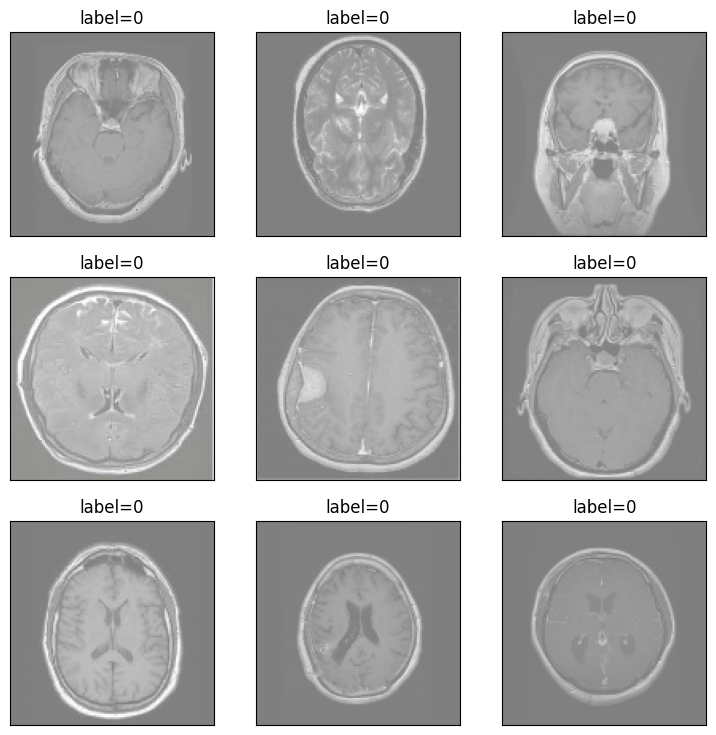

In [ ]:
# Show some images with their labels.
if isinstance(batch, dict) and 'image' in batch:
    # If batch is a dictionary and 'image' key exists
    images, labels = batch['image'][0][:9], batch['label'][0][:9]
else:
    # If batch is a tuple, assume 'image' is the first element
    images, labels = batch[0][:9], batch[1][:9]

# Check if labels is 1D, and if so, convert it to 2D
if len(labels.shape) == 1:
    labels = labels.reshape(-1, 1)

# Convert labels to integers if they are floats
if labels.dtype == float:
    labels = labels.astype(int)

# Ensure that images are normalized to [0, 1] range
images_normalized = (images.astype(float) - images.min()) / (images.max() - images.min())

titles = map(make_label_getter(dataset), labels.argmax(axis=1))
show_img_grid(images_normalized, titles)


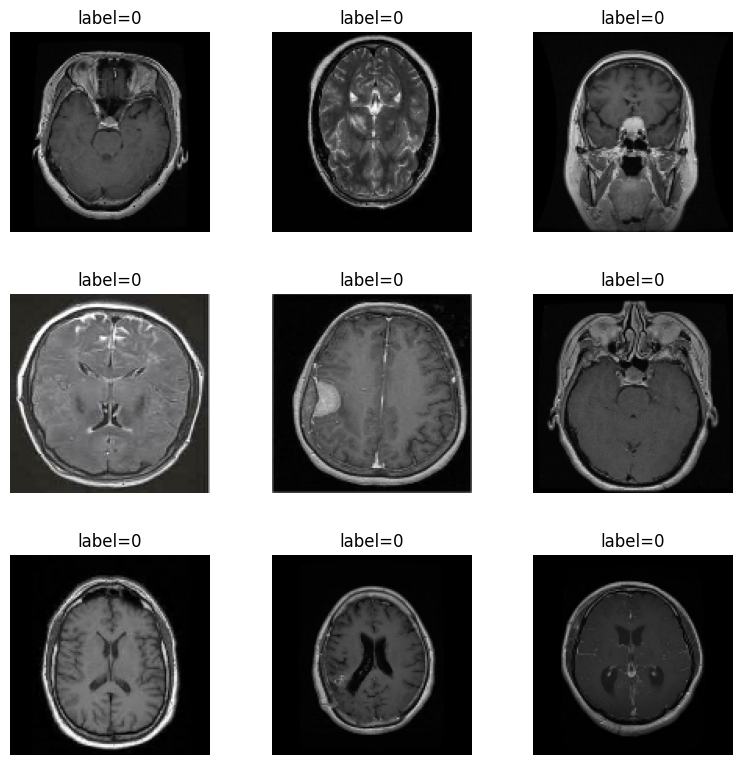

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

images_normalized = images.astype(float) / 255.0
images_clipped = np.clip(images_normalized, 0, 1)


titles_list = list(map(make_label_getter(dataset), labels.argmax(axis=1)))


fig, axes = plt.subplots(3, 3, figsize=(8, 8))
fig.tight_layout()

for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(images_clipped[i])
    ax.set_title(titles_list[i])
    ax.axis('off')

plt.show()


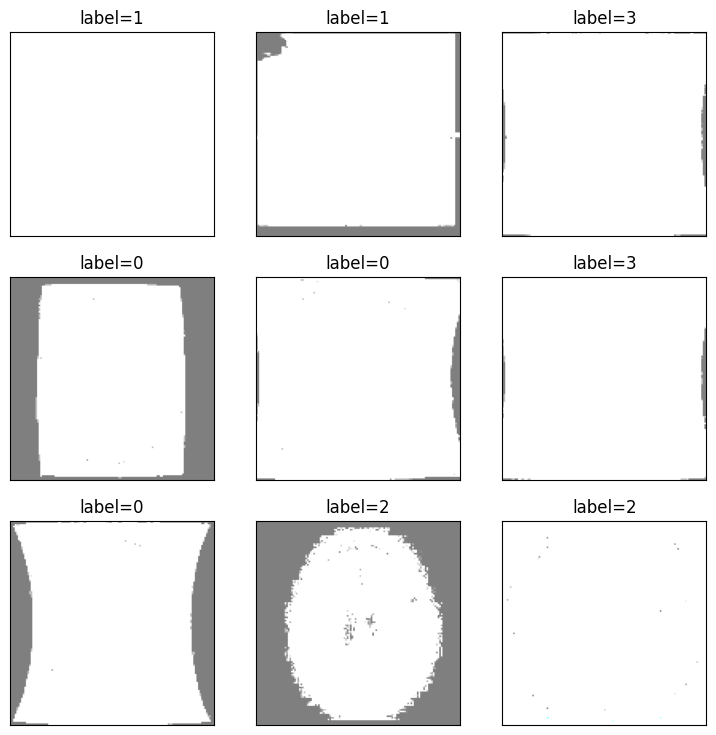

In [ ]:
# Show some images with their labels.
if isinstance(batch, dict) and 'image' in batch:
    # If batch is a dictionary and 'image' key exists
    images, labels = batch['image'][0][:9], batch['label'][0][:9]
else:
    # If batch is a tuple, assume 'image' is the first element
    images, labels = batch[0][:9], batch[1][:9]

# Check if labels is 1D, and if so, convert it to 2D
if len(labels.shape) == 1:
    labels = labels.reshape(-1, 1)

# Create a list of titles based on the labels
titles_list = [make_label_getter(dataset)(label) for label in labels.flatten()]

# Display images with titles
show_img_grid(images, titles_list)


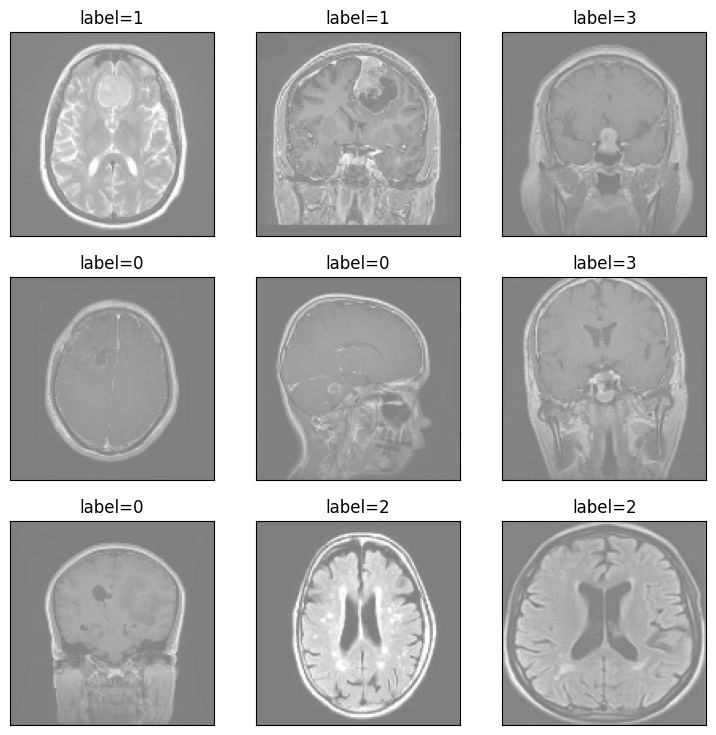

In [ ]:
# Show some images with their labels.
if isinstance(batch, dict) and 'image' in batch:
    # If batch is a dictionary and 'image' key exists
    images, labels = batch['image'][0][:9], batch['label'][0][:9]
else:
    # If batch is a tuple, assume 'image' is the first element
    images, labels = batch[0][:9], batch[1][:9]

# Check if labels is 1D, and if so, convert it to 2D
if len(labels.shape) == 1:
    labels = labels.reshape(-1, 1)

# Convert images to float and normalize to [0, 1]
images_normalized = images.astype(float) / 255.0

# Create a list of titles based on the labels
titles_list = [make_label_getter(dataset)(label) for label in labels.flatten()]

# Display images with titles
show_img_grid(images_normalized, titles_list)


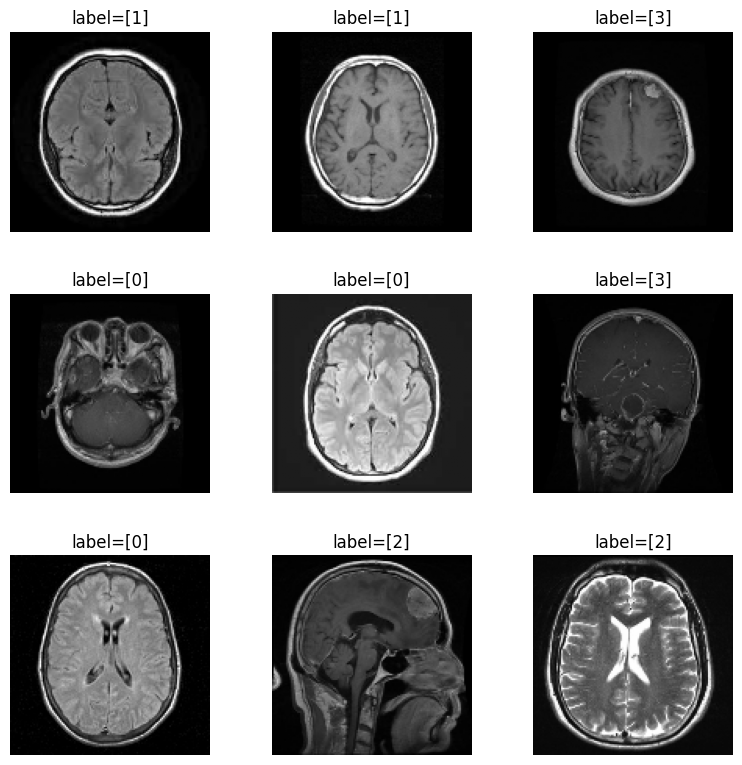

In [ ]:
# Same as above, but with train images.
# Note how images are cropped/scaled differently.
# Check out input_pipeline.get_data() in the editor at your right to see how the
# images are preprocessed differently.
import matplotlib.pyplot as plt
import numpy as np

images_normalized = images.astype(float) / 255.0
images_clipped = np.clip(images_normalized, 0, 1)


fig, axes = plt.subplots(3, 3, figsize=(8, 8))
fig.tight_layout()

for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(images_clipped[i])
    ax.set_title(titles_list[i])
    ax.axis('off')

plt.show()


LOAD PRE-TRAINED

In [ ]:
model_config = models_config.MODEL_CONFIGS[model_name]
model_config

classifier: token
hidden_size: 768
model_name: ViT-B_32
patches:
  size: !!python/tuple
  - 32
  - 32
representation_size: null
transformer:
  attention_dropout_rate: 0.0
  dropout_rate: 0.0
  mlp_dim: 3072
  num_heads: 12
  num_layers: 12

In [ ]:
import flax.linen as nn
import jax
import jax.numpy as jnp

class VisionTransformer(nn.Module):
    hidden_size: int
    num_heads: int
    num_classes: int
    mlp_dim: int
    num_layers: int
    patch_size: int

    def setup(self):
        self.patch_embedding = nn.Conv(
            features=self.hidden_size,
            kernel_size=(self.patch_size, self.patch_size),
            strides=(self.patch_size, self.patch_size),
            padding="VALID",
            name="patch_embedding",
        )
        self.transformer = nn.Transformer(
            num_heads=self.num_heads,
            dtype=jax.numpy.float32,
            kernel_init=nn.initializers.xavier_uniform(),
        )
        self.mlp_head = nn.Sequential([
            nn.GlobalMeanPool(),
            nn.Dense(self.mlp_dim),
            nn.relu,
            nn.Dense(self.num_classes),
        ])

    def __call__(self, x):
        # Assuming input shape is (batch_size, height, width, channels)
        batch_size, height, width, channels = x.shape
        x = self.patch_embedding(x)
        x = x.reshape((batch_size, -1, self.hidden_size))
        x = self.transformer(x)
        x = self.mlp_head(x)
        return x


model_config = {
    'patch_size': 16,
    'num_layers': 12,
    'hidden_size': 768,
    'num_heads': 12,
    'mlp_dim': 3072,
    'num_classes': num_classes,
}
model = VisionTransformer(**model_config)


In [ ]:
!pip install flax==0.8.1


In [ ]:
import flax.linen as nn
import jax

class VisionTransformer(nn.Module):
    hidden_size: int
    num_heads: int
    num_classes: int
    mlp_dim: int
    num_layers: int
    patch_size: int

    def setup(self):
        self.patch_embedding = nn.Conv(
            features=self.hidden_size,
            kernel_size=(self.patch_size, self.patch_size),
            strides=(self.patch_size, self.patch_size),
            padding="VALID",
            name="patch_embedding",
        )


        self.transformer = nn.attention.MultiHeadDotProductAttention(
            num_heads=self.num_heads,
            dtype=jax.numpy.float32,
            kernel_init=nn.initializers.xavier_uniform(),
        )

        self.mlp_head = nn.Sequential([
            nn.GlobalMeanPool(),
            nn.Dense(self.mlp_dim),
            nn.relu,
            nn.Dense(self.num_classes),
        ])

    def __call__(self, x):
        batch_size, height, width, channels = x.shape
        x = self.patch_embedding(x)
        x = x.reshape((batch_size, -1, self.hidden_size))


        x = self.transformer(x)

        x = self.mlp_head(x)
        return x


In [ ]:
# Inisialisasi model
model_config = {
    'patch_size': 16,
    'num_layers': 12,
    'hidden_size': 768,
    'num_heads': 12,
    'mlp_dim': 3072,
    'num_classes': num_classes,
}
model = VisionTransformer(**model_config)


In [ ]:
import flax.linen as nn
import jax.numpy as jnp

class GlobalMeanPool(nn.Module):
    def __call__(self, x):
        return jnp.mean(x, axis=(1, 2))

class VisionTransformer(nn.Module):
    hidden_size: int
    num_heads: int
    num_classes: int
    mlp_dim: int
    num_layers: int
    patch_size: int

    def setup(self):
        self.patch_embedding = nn.Conv(
            features=self.hidden_size,
            kernel_size=(self.patch_size, self.patch_size),
            strides=(self.patch_size, self.patch_size),
            padding="VALID",
            name="patch_embedding",
        )
        self.transformer_blocks = [TransformerBlock(num_heads=self.num_heads, head_features=self.hidden_size // self.num_heads, mlp_dim=self.mlp_dim) for _ in range(self.num_layers)]
        self.mlp_head = nn.Sequential([
            GlobalMeanPool(),
            nn.Dense(self.mlp_dim),
            nn.relu,
            nn.Dense(self.num_classes),
        ])

    def __call__(self, x):
        batch_size, height, width, channels = x.shape
        x = self.patch_embedding(x)
        x = x.reshape((batch_size, -1, self.hidden_size))
        for block in self.transformer_blocks:
            x = block(x)
        x = self.mlp_head(x)
        return x


# Konfigurasi model
model_config = {
    'hidden_size': 768,
    'num_heads': 12,
    'num_classes': num_classes,
    'mlp_dim': 3072,
    'num_layers': 12,
    'patch_size': 16,
}

# Inisialisasi model
model = VisionTransformer(**model_config)

# Load checkpoint
pretrained_path = 'path/to/your/pretrained_model.npz'
init_params = model.init(jax.random.PRNGKey(0), jnp.ones((1, 128, 128, 3)))
params = checkpoints.restore_checkpoint(pretrained_path, init_params)


TypeError: add got incompatible shapes for broadcasting: (1, 64, 768), (1, 64, 64).

In [ ]:
import flax.linen as nn
import jax
import jax.numpy as jnp

class VisionTransformer(nn.Module):
    hidden_size: int
    num_heads: int
    num_classes: int
    mlp_dim: int
    num_layers: int
    patch_size: int

    def setup(self):
        self.patch_embedding = nn.Conv(
            features=self.hidden_size,
            kernel_size=(self.patch_size, self.patch_size),
            strides=(self.patch_size, self.patch_size),
            padding="VALID",
            name="patch_embedding",
        )
        self.transformer = nn.Sequential(
            *[TransformerBlock(self.num_heads, self.hidden_size, self.mlp_dim) for _ in range(self.num_layers)]
        )
        self.mlp_head = nn.Sequential([
            nn.LayerNorm(name="pre_logits_norm"),
            nn.GlobalMeanPool(),
            nn.Dense(self.mlp_dim),
            nn.relu,
            nn.Dropout(rate=0.5),
            nn.Dense(self.num_classes),
        ])

    def __call__(self, x):
        # Assuming input shape is (batch_size, height, width, channels)
        batch_size, height, width, channels = x.shape
        x = self.patch_embedding(x)
        x = x.reshape((batch_size, -1, self.hidden_size))
        x = self.transformer(x)
        x = self.mlp_head(x)
        return x

class TransformerBlock(nn.Module):
    num_heads: int
    head_features: int
    mlp_dim: int
    dropout_rate: float = 0.1

    def setup(self):
        self.attention = nn.SelfAttention(num_heads=self.num_heads, dtype=jax.numpy.float32)
        self.norm1 = nn.LayerNorm(name="attention_norm")
        self.mlp = nn.Sequential(
            nn.Dense(self.mlp_dim),
            nn.relu,
            nn.Dropout(rate=self.dropout_rate),
            nn.Dense(self.head_features),
        )
        self.norm2 = nn.LayerNorm(name="mlp_norm")

    def __call__(self, x):
        # Attention
        attn_output = self.attention(x)
        x = x + attn_output
        x = self.norm1(x)

        # MLP
        mlp_output = self.mlp(x)
        x = x + mlp_output
        x = self.norm2(x)

        return x


In [ ]:
import flax
from flax import linen as nn
from flax.training import checkpoints

# Gantilah model_name sesuai dengan nama model yang Anda gunakan
model_name = 'VisionTransformer'

# Buat model
model_config = {
    'patch_size': 16,
    'num_layers': 12,
    'hidden_size': 768,
    'num_heads': 12,
    'mlp_dim': 3072,
    'num_classes': num_classes,
}
model = VisionTransformer(**model_config)

# Load dan convert pretrained checkpoint.
# Ini melibatkan memuat hasil model yang sebenarnya yang telah dilatih sebelumnya, tetapi kemudian juga
# memodifikasi parameter sedikit, misalnya mengubah lapisan terakhir, dan mengubah ukuran
# posisional embeddings.
# Untuk detailnya, lihatlah kode dan metode di makalah tersebut.
params = checkpoints.restore_checkpoint(
    f'ViT-B_32.npz',
    init_params=model.init(jax.random.PRNGKey(0), jnp.ones((1, 128, 128, 3), dtype=jnp.float32)),
    model=model,
)

# Apply parameters to the model
model = model.bind(params)

# Sekarang model siap untuk digunakan!


TypeError: VisionTransformer.__init__() got an unexpected keyword argument 'patch_size'

In [ ]:
import flax.linen as nn
import jax
import jax.numpy as jnp

class VisionTransformer(nn.Module):
    def setup(self):
        # Tambahkan definisi layer dan konfigurasi lainnya
        self.patch_embedding = nn.Conv(
            features=self.hidden_size,
            kernel_size=(self.patch_size, self.patch_size),
            strides=(self.patch_size, self.patch_size),
            padding="VALID",
            name="patch_embedding",
        )
        self.transformer = nn.Transformer(
            num_heads=self.num_heads,
            dtype=jax.numpy.float32,
            kernel_init=nn.initializers.xavier_uniform(),
        )
        self.mlp_head = nn.Sequential([
            nn.GlobalMeanPool(),
            nn.Dense(self.mlp_dim),
            nn.relu,
            nn.Dense(self.num_classes),
        ])

    def __call__(self, x, **kwargs):
        # Tambahan parameter **kwargs untuk menerima argumen tambahan
        # Lakukan sesuatu dengan argumen tambahan jika diperlukan
        return self.apply({'params': kwargs}, x)


In [ ]:
model_config = {
    'patch_size': 16,
    'num_layers': 12,
    'hidden_size': 768,
    'num_heads': 12,
    'mlp_dim': 3072,
    'num_classes': num_classes,
}

model = VisionTransformer(**model_config)


TypeError: VisionTransformer.__init__() got an unexpected keyword argument 'patch_size'

In [ ]:
import flax.linen as nn
import jax.numpy as jnp

class VisionTransformer(nn.Module):
    hidden_size: int
    num_heads: int
    num_classes: int
    mlp_dim: int
    num_layers: int
    patch_size: int

    def setup(self):
        # Tambahkan definisi layer dan konfigurasi lainnya
        self.patch_embedding = nn.Conv(
            features=self.hidden_size,
            kernel_size=(self.patch_size, self.patch_size),
            strides=(self.patch_size, self.patch_size),
            padding="VALID",
            name="patch_embedding",
        )
        self.transformer = nn.Transformer(
            num_heads=self.num_heads,
            dtype=jnp.float32,
            kernel_init=nn.initializers.xavier_uniform(),
        )
        self.mlp_head = nn.Sequential([
            nn.GlobalMeanPool(),
            nn.Dense(self.mlp_dim),
            nn.relu,
            nn.Dense(self.num_classes),
        ])

    def __call__(self, x):
        # Tambahkan logika pemrosesan data di sini
        x = self.patch_embedding(x)
        x = x.reshape((x.shape[0], -1, self.hidden_size))
        x = self.transformer(x)
        x = self.mlp_head(x)
        return x


In [ ]:
import flax
from flax import linen as nn
import jax
import jax.numpy as jnp
from flax.training import checkpoints

checkpoint_path = '/content/ViT-B_32.npz'
params = checkpoints.restore_checkpoint(checkpoint_path)

# Create an instance of your model
model = VisionTransformer(**model_config)
# Initialize model parameters
dummy_input = jnp.ones((1, height, width, channels), dtype=jnp.float32)
variables = model.init(jax.random.PRNGKey(0), dummy_input, train=False)

# Update model parameters with pretrained values
model_params = jax.tree_util.tree_multimap(lambda x, y: y, variables['params'], params)
variables = variables.replace(params=model_params)


TypeError: restore_checkpoint() missing 1 required positional argument: 'target'